# Deep Learning Assignment 3
## Author: Akash K S
## Roll No: CS22MTECH11012

## 1. Variants of Backprop for visualizing CNNs

In [1]:
# Author : Akash K S
# Roll No : CS22MTECH11012

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### Added the images into the folder as the images are directly read from the local directory

In [2]:
# function to pre process the images
def preprocess():
  preprocessed_images = []
  images=['i1.jpg', 'i2.jpg', 'i3.jpg', 'i4.jpg', 'i5.jpg']
  # Take images from the images list one by one and preprocess them
  for img in images:
    image = Image.open(img)
    preprocess = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_img = preprocess(image).unsqueeze(0)
    
    #append the preprocessed image into a list
    preprocessed_images.append(input_img)

  return preprocessed_images

In [3]:
# function to visualize the input image and it's corresponding visualization heat map
def visualize_output(input_image, output_img, type, cmap):
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(input_image.detach().numpy().transpose(1, 2, 0))
  ax[0].set_title('Input Image')
  ax[0].axis('off')
  if type == 'CAM' or type == 'Grad CAM':
    ax[1].imshow(img_tensor[0].detach().numpy().transpose(1,2,0))
    ax[1].imshow(heatmap, alpha = 0.5, cmap = 'jet')
  else:
    if len(output_img.shape) > 2:
      ax[1].imshow(output_img.transpose(1, 2, 0),cmap=cmap)
    else:
      ax[1].imshow(output_img,cmap=cmap)

  ax[1].set_title(type)
  ax[1].axis('off')
  plt.tight_layout()
  plt.show()

### 1. Vanilla Backprop

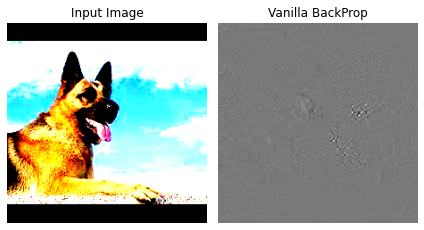

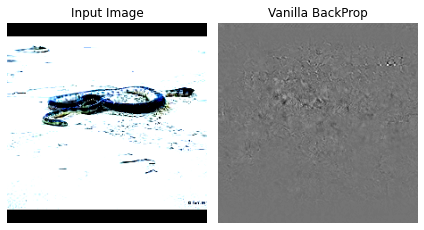

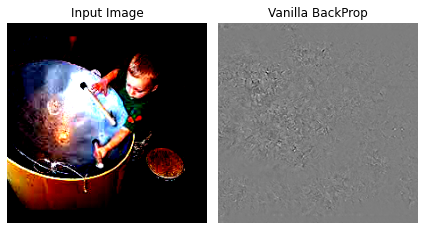

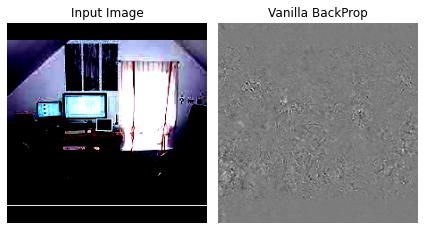

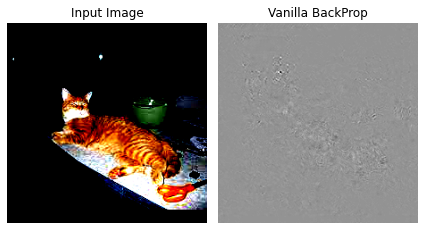

In [ ]:
# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

# preprocess the images and save them in a list
images_list = preprocess()

#perfrom vanilla backprop for every image one by one
for input_img in images_list:
  #To avoid vanishing gradients
  input_img.requires_grad_()

  # feed the image to resnet 50 for prediction
  output = resnet50(input_img)

  #taking the index of the neuron with highest score
  pred_index = output.argmax()

  # converting the output to one hot vector with 1 in the index of neuron with highest score and zeros for all others
  one_hot_output = torch.zeros_like(output)
  one_hot_output[0][pred_index] = 1

  #finding the gradients of output with respect to the input image
  output.backward(gradient=one_hot_output)
  gradients = input_img.grad.data
  
  #generating heat map for the obtained gradients to visualize the gradients
  heatmap = gradients.mean(dim=0).squeeze()
  heatmap = heatmap.detach().numpy() 

  #visualizing the input image and it's respective heat map
  visualize_output(input_img[0], heatmap[0], 'Vanilla BackProp', 'gist_gray_r')

### 2. Guided Backprop

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


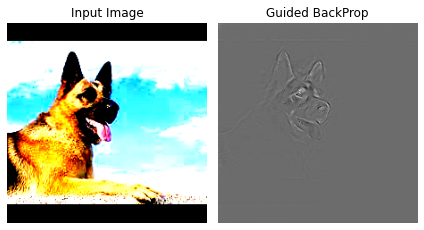

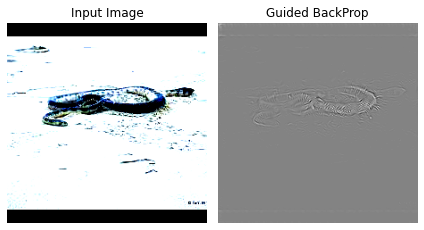

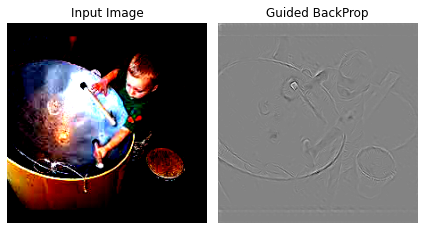

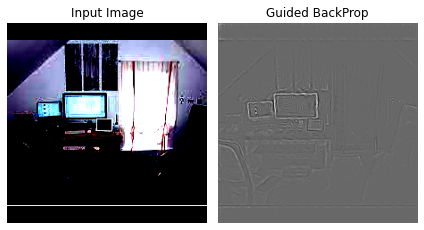

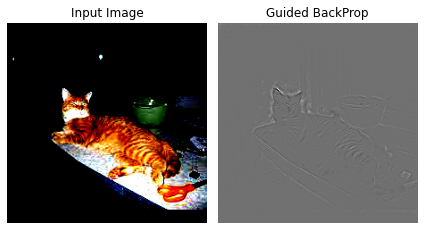

In [5]:
# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
# preprocess the images and save them in a list
images_list = preprocess()

# adding hooks to ReLU layers for backward propagations
for module in resnet50.modules():
  if isinstance(module, nn.ReLU):
    module.register_backward_hook(lambda _, grad_out, __: (torch.clamp(grad_out[0], min=0.0),))
  elif isinstance(module, nn.ReLU6):
    module.register_backward_hook(lambda _, grad_out, __: (torch.clamp(grad_out[0], min=0.0, max=1.0),))

# declaring a list to store the guided backprops of all input images.
# This will be further used to implement guided grad cam
guided_backprop = []

for input_img in images_list:
  #To avoid vanishing gradients
  input_img.requires_grad_()

  # feed the image to resnet 50 for prediction
  output = resnet50(input_img)

  #taking the index of the neuron with highest score
  pred_index = output.argmax()

  # converting the output to one hot vector with 1 in the index of neuron with highest score and zeros for all others
  one_hot_output = torch.zeros_like(output)
  one_hot_output[0][pred_index] = 1

  #finding the gradients of output with respect to the input image
  output.backward(gradient=one_hot_output)
  gradients = input_img.grad.data

  #generating heat map for the obtained gradients to visualize the gradients
  heatmap = gradients.mean(dim=0).squeeze()
  heatmap = heatmap.detach().numpy()

  # appending the guided backprop heat map to the list
  guided_backprop.append(heatmap[0])

  #visualizing the input image and it's respective heat map
  visualize_output(input_img[0], heatmap[0], 'Guided BackProp', 'gist_gray_r')

### 3. Class Activation Map (CAM)

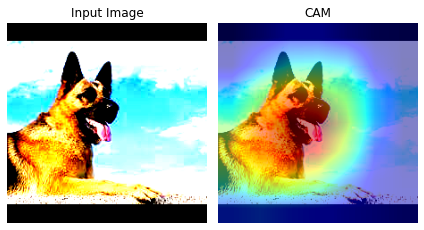

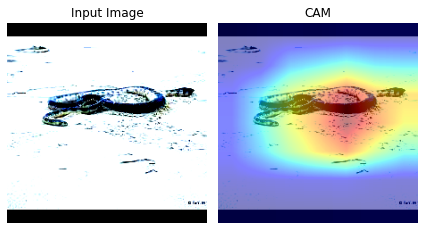

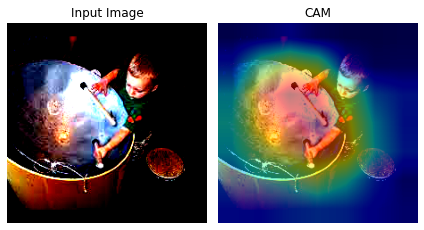

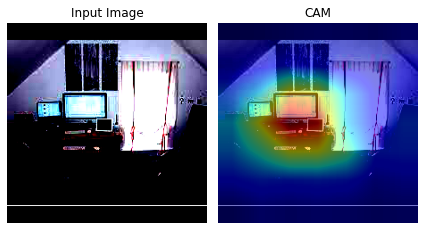

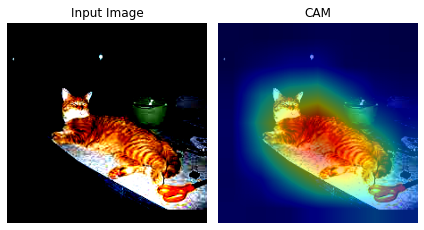

In [ ]:
# class to register hook and save features
class CAM():
    features = None
    
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)
        
    def hook_func(self, module, input, output):
        self.features = output.cpu().data.numpy()
        
    def close(self):
        self.hook.remove()

#function to generate CAM
def generate_CAM(feature_map, weights):
  d1, d2, d3, d4 = feature_map.shape
  cam = np.dot(weights, feature_map.reshape(d2, d3*d4))
  cam = cam.reshape(d3, d4)
  cam = cam - np.min(cam)
  CAM = cam / np.max(cam)
  return CAM

# Load resnet 50 model and evaluate
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

# preprocess input images and store them in a list
image_list = preprocess()

# removing the fully connected layers from resnet 50 model
last_layer = resnet50._modules.get('layer4')

# adding hook to the last layer
CAM_hook = CAM(last_layer)

# getting the weights of the fully connected layer
fc_weights = resnet50.fc.weight.data

# computing CAM for every input image one by one
for img_tensor in image_list:
  #To avoid vanishing gradients
  img_tensor.requires_grad_()

  # feed the image to resnet 50 for prediction
  #output = resnet50(img_tensor)
  output = resnet50(img_tensor)

  #taking the index of the neuron which have highest pred score
  pred_index = torch.argmax(output, dim=1).item()

  # set gradients to zero initially
  resnet50.zero_grad()

  # get feature maps from 
  feature_map = CAM_hook.features

  weights = fc_weights[pred_index]

  # generate CAM with obtained feature map and weights
  CAM = generate_CAM(feature_map, weights)

  # pil image to resize the obtained CAM into size of the input image
  heatmap = Image.fromarray(np.uint8(CAM * 255))
  heatmap = heatmap.resize((img_tensor.shape[2], img_tensor.shape[3]), resample=Image.BILINEAR)

  #covert img to numpy
  heatmap = np.array(heatmap) / 255.0
  #print(heatmap.shape)
  
  '''plt.imshow(img_tensor[0].detach().numpy().transpose(1,2,0))
  plt.imshow(heatmap, alpha = 0.5, cmap = 'jet')
  plt.show()'''

  # display the input image and CAM heat map
  visualize_output(img_tensor[0], heatmap, 'CAM', 'jet')

CAM_hook.close()

### 4. Grad CAM

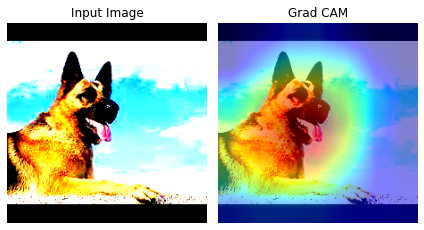

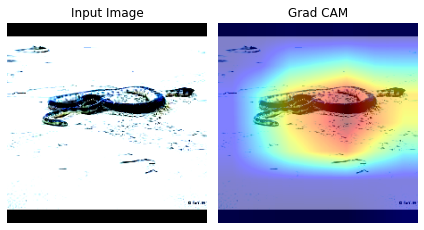

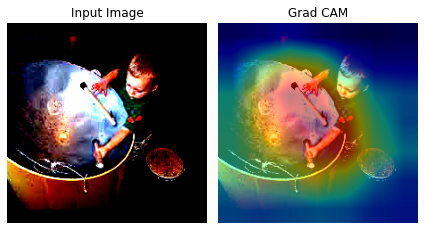

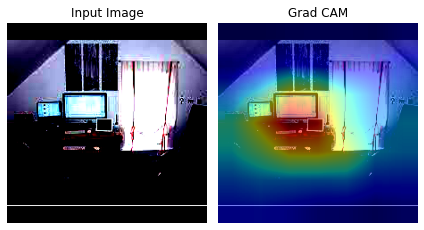

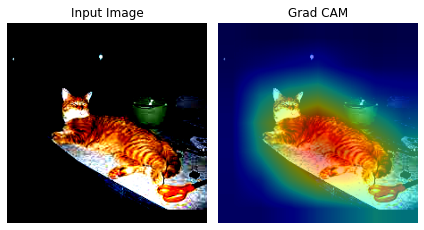

In [6]:
# class to register forward and backward hooks to save features and gradients
class GradCAM():
  feature_map = None
  gradient = None

  def __init__(self, model):
      self.hook1 = model.register_forward_hook(self.forward_hook)
      self.hook2 = model.register_backward_hook(self.backward_hook)
      
  def forward_hook(self, module, input, output):
      self.feature_map = output.detach()

  def backward_hook(self, module, grad_in, grad_out):
      self.gradient = nn.functional.relu(grad_out[0].detach())

  def close(self):
      self.hook1.remove()
      self.hook2.remove()

# function to generate CAM using pooled weights and feature maps
def generate_Grad_CAM(features, gradients):
  weights = nn.functional.adaptive_avg_pool2d(gradients, 1).squeeze().numpy()
  cam = np.zeros(features.shape[1:])
  for i,w in enumerate(weights):
    cam += w*features[i,:]
  cam = np.maximum(cam, 0)
  cam = cam -  cam.min()
  cam = cam / np.max(cam) * 255.0
  return cam

# load the resnet 50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

# preprocess input images and store them in a list
image_list = preprocess()

# take 4th conv later of resnet 50
last_layer = resnet50._modules.get('layer4')

#register hooks to save features
Grad_CAM_hook = GradCAM(last_layer)

# initialize a list to store the grad cam heat maps. This will be used to implement guided grad cams
grad_cam = []

for img_tensor in image_list:
  #To avoid vanishing gradients
  img_tensor.requires_grad_()

  # feed the image to resnet 50 for prediction
  output = resnet50(img_tensor)

  # find the predicted score and index of neuron with higest score
  pred_score, pred_index = torch.max(output, dim=1)

  # preforms backpropagation from the predicted neuron
  pred_score.backward()

  # get the features out from the model
  features = Grad_CAM_hook.feature_map.squeeze().numpy()
  
  #get the gradients out of the model
  gradients = Grad_CAM_hook.gradient.squeeze()

  #generate grad cam using obtained features and gradients
  Grad_CAM = generate_Grad_CAM(features, gradients)
  
  # pil image to resize the obtained CAM into size of the input image
  heatmap = Image.fromarray(np.uint8(Grad_CAM))
  heatmap = heatmap.resize((img_tensor.shape[2], img_tensor.shape[3]), resample=Image.BILINEAR)

  #covert img to 
  heatmap = np.array(heatmap) / 255.0

  grad_cam.append(heatmap)

  #heatmap = np.array([heatmap, heatmap, heatmap])

  #overlay = 0.1 * img_tensor[0].detach().numpy() + 0.9 * heatmap

  # display the input image and CAM heat map
  visualize_output(img_tensor[0], heatmap, 'Grad CAM', 'jet')

Grad_CAM_hook.close()

### Guided Grad CAM

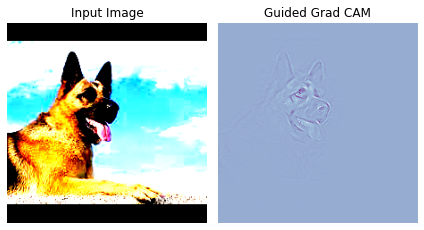

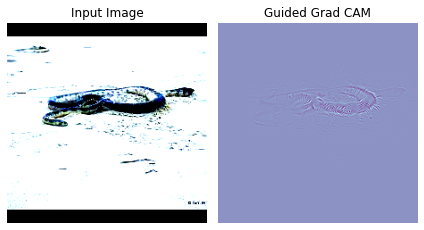

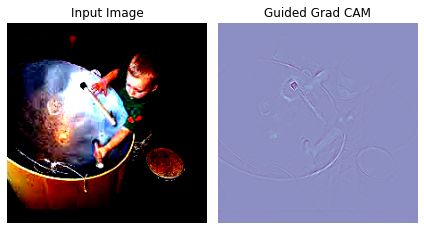

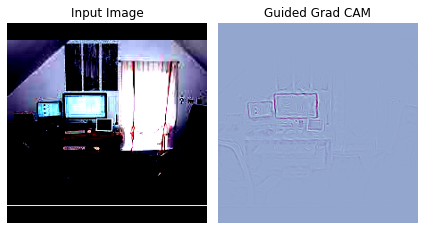

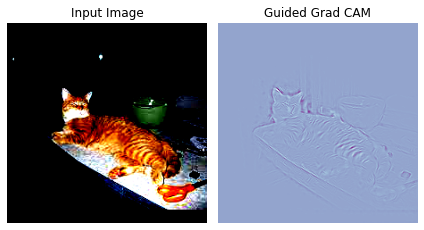

In [20]:
#taking the outputs of guided backprop and grad cam and multiplying them element wise to get guided grad cam
image_list = preprocess()
for i in range(len(grad_cam)):
  guided_gradcam = np.multiply(grad_cam[i], guided_backprop[i])
  visualize_output(image_list[i][0], guided_gradcam, 'Guided Grad CAM', 'BuPu_r')

## 2. SGD Update rule variations

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [ ]:
# function to compute the give function f(x, y) = 10 * X^2 + Y^2
def func_Fxy(X, Y):
  return 10 * np.square(X) + np.square(Y)

In [ ]:
# fucntion to calculate the gradient of the function
def grad_Fxy(x, y):
  return np.array([20 * x, 2 * y])

### Vanilla SGD

In [ ]:
def vanilla_SGD(W, lr, num_iterations):
  # declaring a list to save all the gradients. Returned to use in creating GIF
  saveW = []
  saveW.append(W)
  # Update the parameters using SGD
  for i in range(num_iterations):
    # calculating the gradient
    grad = grad_Fxy(*W)

    # Updating the W parameter
    W = W - lr * grad
    #Saving the W pararmeter
    saveW.append(W)

  return np.array(saveW)

### SGD with Momentum

In [ ]:
# function for SGD with Momentum
def SGD_Momentum(W, lr, num_iterations):
  # setting friction to 0.9
  rho = 0.9
  # initialting the momentum to zero
  v = 0

  # declaring a list to save all the gradients. Returned to use in creating GIF
  saveW = []
  saveW.append(W)
  prev_v = 0
  for i in range(num_iterations):
    grad = 0
    # calculating the gradient
    grad = grad_Fxy(*W)
    
    # Updating the velocity
    v = rho * prev_v + lr * grad
    
    # Updating the W parameter
    W = W - v

    prev_v = v
    # Saving the W parameter in list
    saveW.append(W)

  return np.array(saveW)

### Nesterov Momentum

In [ ]:
# fucntion to calculate Nestrov's Momentum
def Nesterov_Momentum(W, lr, num_iterations):
  # setting friction to 0.9
  rho = 0.9
  # initialting the momentum to zero
  prev_v = v = 0

  # declaring a list to save all the gradients. Returned to use in creating GIF
  saveW = []
  saveW.append(W)
  for i in range(num_iterations):
    grad = 0
    
    upd_W = rho * prev_v
    # calculating the gradient
    grad = grad_Fxy(*(W - upd_W))

    # Updating the velocity
    v = rho * prev_v + lr * grad

    # Updating the W parameter
    W = W - v

    prev_v = v
    # Saving the W parameter in list
    saveW.append(W)

  return np.array(saveW)

### Ada Grad

In [ ]:
# fucntion to calculate AdaGrad SGD
def AdaGrad(W, lr, num_iterations):
  grad_sq = 0
  
  epsilon = 1e-8
  # declaring a list to save all the gradients. Returned to use in creating GIF
  saveW = []
  saveW.append(W)

  for i in range(num_iterations):
    # calculating the gradient
    grad = grad_Fxy(*W)

    # updating the grad_sq by adding it element wise multiplied grad
    grad_sq = grad_sq + (grad * grad)

    # update the learning rate
    lr_updated = lr / (np.sqrt(grad_sq) + epsilon)

    # updating the W
    W = W - lr_updated * grad

    # Saving the W parameter in list
    saveW.append(W)

  return np.array(saveW)

### RMS Prop

In [ ]:
# func to calculate RMS Prop
def RMS_Prop(W, lr, num_iterations):
  grad_sq = 0

  rho = 0.9

  epsilon = 1e-8
  # declaring a list to save all the gradients. Returned to use in creating GIF
  saveW = []
  saveW.append(W)

  for i in range(num_iterations):
    # calculating the gradient
    grad = grad_Fxy(*W)

    # updating the grad_sq 
    grad_sq = rho * grad_sq + (1 - rho) * (grad * grad)

    # update learning rate
    lr_updated = lr / (epsilon + np.sqrt(grad_sq))

    # updating the W
    W = W - lr_updated * grad

    # Saving the W parameter in list
    saveW.append(W)

  return np.array(saveW)

### Visualizing using GIF

In [ ]:
# function to create GIF

def visualise_GIF(W, num_iterations):

  x_range = np.linspace(-20, 20, 100)
  y_range = np.linspace(-20, 20, 100)
  X, Y = np.meshgrid(x_range, y_range)
  Fxy = func_Fxy(X, Y)

  # Create a list to store the images for the GIF
  images = []

  saveX, saveY = [], []

  path_colors = ['red', 'white', 'cyan', 'green', 'orange']
  types = ['SGD', 'SGD_M', 'Nesterov', 'AdaGrad', 'RMS']

  for i in range(W.shape[1]):
    # Saving all the previous updated points
    saveX.append(W[:, i, :][:,0])
    saveY.append(W[:, i, :][:,1])

    saveX_np = np.array(saveX)
    saveY_np = np.array(saveY)

    # Create a plot of the function surface and the current point
    fig = plt.figure(dpi = 200)
    ax = fig.add_subplot(projection='3d')
    #ax.plot_surface(X, Y, Fxy, cmap='coolwarm')
    ax.contourf(X, Y, Fxy, cmap='viridis', zdir='z', offset=-100)
    # Set the viewpoint to an upper view
    ax.view_init(elev=90, azim=0)

    # scattering the obtained gradients on the contour map
    for k in range(saveX_np.shape[1]):
      ax.scatter(saveX_np[:, k], saveY_np[:,k], func_Fxy(saveX_np[:,k], saveY_np[:,k]), c = path_colors[k], s=20)
    
    # create handles for legend
    handle = []
    for p in range(len(path_colors)):
      handle.append(mlines.Line2D([], [], color=path_colors[p], marker='o', linestyle='None', markersize = 4, label=types[p]))

    #add labels to the contour plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Iteration {}'.format(i))

    ax.legend(loc='center right', handles=handle)
    # Save the plot as an image
    filename = 'iteration_{}.png'.format(i)
    plt.savefig(filename)
    
    # Append the image to the list of images
    images.append(imageio.imread(filename))

    # Close the plot
    plt.close()
  
  # Create the GIF from the list of images
  imageio.mimsave('Question_2_convergence.gif', images, fps=5)

### 1. Below cell acts as driver code for the Problem 2. This will generate GIF and store in local directory. I have also added the GIF generated by this script in the zipped folder

### 2. Tried different learning rates and chose 0.1 for vanilla, SGD+M and Nesterov and 0.01 for Adagrad and RMS Prop

In [ ]:
# defining the learning rate
learning_rate = 0.01

# different learning rate for RMS and Adagrad
learning_rate1 = 0.1

# Define the starting point relatively far from the global minima
x_init = -17.6
y_init = -19.5
#x_init = np.random.uniform(-20, 20)
#y_init = np.random.uniform(-20, 20)
W_init = np.array([x_init, y_init])

# Define the number of iterations
num_iterations = 50

# declaring an array to store the paths taken by grads of every SGD_Type
save_Paths = []

# list with all SGD_Types
SGD_Types = [vanilla_SGD, SGD_Momentum, Nesterov_Momentum, AdaGrad, RMS_Prop]

# call every sgd type and append the paths given by them to list
for SGD_Type in SGD_Types:
  #using different learning rates for different sgd types
  if SGD_Type == AdaGrad or SGD_Type == RMS_Prop:
    W = SGD_Type(W_init, learning_rate1, num_iterations)
  else:
    W = SGD_Type(W_init, learning_rate, num_iterations)
  save_Paths.append(W)

SGD_Paths_array = np.array(save_Paths)
# passing the gradient paths of all sgd types to visualize a GIF
visualise_GIF(SGD_Paths_array, num_iterations)

In [ ]:
# code to play the created gif
from IPython .display import Image as image
image(filename = 'Question_2_convergence.gif')

Output hidden; open in https://colab.research.google.com to view.